# Обучение эмбеддингов (Metric Learning)
Данные, необходимые для этого модуля:
* symbol_a1.png
* symbol_a2.png
* symbol_b1.png

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

## Переключение версии TensorFlow

In [3]:
# %tensorflow_version 2.x

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
# import tensorflow_datasets as tfds

## Загрузка и подготовка датасета LFW

In [5]:
dataset_url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='lfw',
                                   untar=True)
import pathlib
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(data_dir, image_count)

C:\Users\Ifl\.keras\datasets\lfw 13233


In [6]:
# !ls /root/.keras/datasets/lfw/Vladimir_Putin

## Визуализация датасета LFW

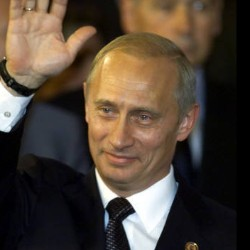

In [7]:
import PIL
import PIL.Image
PIL.Image.open(str(list(data_dir.glob('Vladimir_Putin/*'))[0]))

## Создание модели CNN

In [8]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13233 files belonging to 5749 classes.
Using 11910 files for training.


In [9]:
class_names = train_ds.class_names

In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13233 files belonging to 5749 classes.
Using 1323 files for validation.


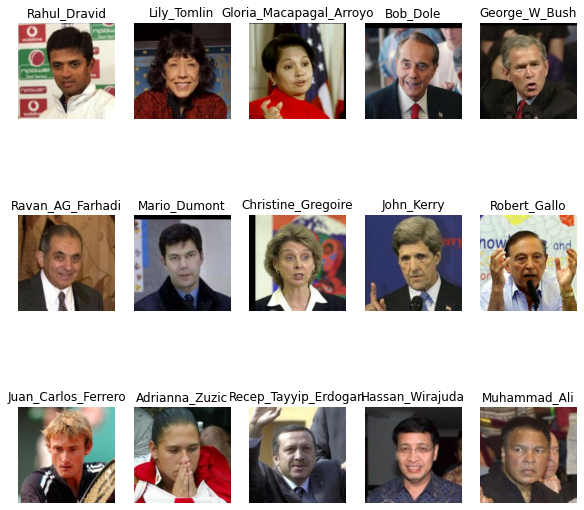

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
EMB_SIZE = 256

model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255), # normalization layer
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [13]:
MARGIN = 20.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [14]:
NUM_EPOCHS = 1

train_ds = train_ds.repeat(NUM_EPOCHS)

## Подготовка к обучению

In [15]:
LEARNING_RATE = 0.00001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [16]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 20 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 358.30291748046875
[20] Loss: 134.10250854492188
[40] Loss: 97.61541748046875
[60] Loss: 56.63840103149414
[80] Loss: 15.924047470092773
[100] Loss: 19.60132598876953
[120] Loss: 16.946182250976562
[140] Loss: 22.90824317932129
[160] Loss: 10.884092330932617
[180] Loss: 9.761224746704102
[200] Loss: 97.87157440185547
[220] Loss: 5.147479057312012
[240] Loss: 0.0
[260] Loss: 4.9266037940979
[280] Loss: 0.0
[300] Loss: 1.7850149869918823
[320] Loss: 1.1726921796798706
[340] Loss: 2.7880051136016846
[360] Loss: 216.6127471923828
Wall time: 6min 31s


In [20]:
test_data = val_ds.take(1)
val = [(x,y) for x,y in test_data]
test_x = val[0][0].numpy()
test_y = val[0][1].numpy()
test_y

array([5365, 1871, 1047, 1871, 4840, 2175, 4679, 1335, 1871, 3683,  115,
       5094,  792, 4044, 4116,  747, 4012, 5039, 1018, 3956, 1871, 1319,
       1691, 3982, 4878, 2192, 1628, 3062, 2507, 5458, 5707, 2181])

In [23]:
[i for i, j in enumerate(test_y) if j == 1871]

[1, 3, 8, 20]

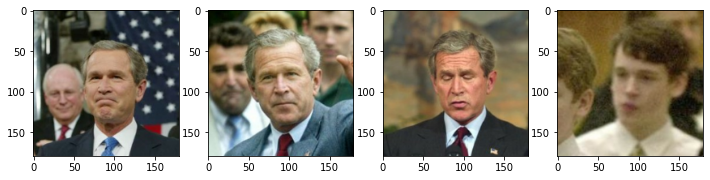

In [25]:
img_a1 = test_x[1]
img_a2 = test_x[3]
img_a3 = test_x[8]
img_b1 = test_x[21]

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a1.astype("uint8"))
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_a2.astype("uint8"))
ax = fig.add_subplot(1, 4, 3)
ax.imshow(img_a3.astype("uint8"))
ax = fig.add_subplot(1, 4, 4)
ax.imshow(img_b1.astype("uint8"))
plt.show()

## Получение эмбеддингов для тестовой выборки

In [27]:
new_embs = model(np.stack((img_a1, img_a2, img_a3, img_b1), axis=0))

def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]
emb4 = new_embs[3,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A1 <-> A3: ', diff(emb1, emb3))
print('A2 <-> A3: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb4))
print('A2 <-> B1: ', diff(emb2, emb4))
print('A3 <-> B1: ', diff(emb3, emb4))

A1 <-> A2:  20.232826014552597
A1 <-> A3:  13.208467853875975
A2 <-> A3:  25.459619001607845
A1 <-> B1:  31.164081105848044
A2 <-> B1:  33.39908533728413
A3 <-> B1:  39.78135126165431


## Функция для визуализации эмбеддингов

## Тестирование на новых данных

In [30]:
import imageio
from skimage.transform import resize

def load_and_prepare_image(fpath):
    img = imageio.imread(fpath)
#     img = img.astype(np.float32) / 255.
    img = resize(img, (180, 180))
    return img

img_a1 = load_and_prepare_image('0.jpg')
img_a2 = load_and_prepare_image('1.jpg')
img_a3 = load_and_prepare_image('2.jpg')
img_b1 = load_and_prepare_image('3.jpg')

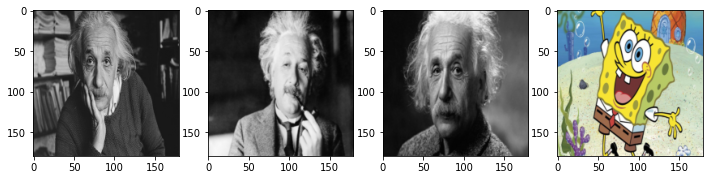

In [31]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a1)
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_a2)
ax = fig.add_subplot(1, 4, 3)
ax.imshow(img_a3)
ax = fig.add_subplot(1, 4, 4)
ax.imshow(img_b1)
plt.show()

In [32]:
new_embs = model(np.stack((img_a1, img_a2, img_a3, img_b1), axis=0))

def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]
emb4 = new_embs[3,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A1 <-> A3: ', diff(emb1, emb3))
print('A2 <-> A3: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb4))
print('A2 <-> B1: ', diff(emb2, emb4))
print('A3 <-> B1: ', diff(emb3, emb4))

A1 <-> A2:  0.1327059823531105
A1 <-> A3:  0.09779270175892059
A2 <-> A3:  0.138228540558057
A1 <-> B1:  0.2586508327763482
A2 <-> B1:  0.2668261717186313
A3 <-> B1:  0.24279540431350954
